<a href="https://colab.research.google.com/github/megasiska86/Neural-Network-Repository/blob/master/fashion_mnist_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir fashion-mnist-master.zip

In [0]:
!rm -rf fashion-mnist-master.zip

In [0]:
!unzip fashion-mnist-master.zip

Archive:  fashion-mnist-master.zip
629abc0f9a73c2897383a9178e8e38f7141be30d
   creating: fashion-mnist-master/
  inflating: fashion-mnist-master/.catwatch.yaml  
 extracting: fashion-mnist-master/.dockerignore  
  inflating: fashion-mnist-master/.gitignore  
  inflating: fashion-mnist-master/.zappr.yaml  
  inflating: fashion-mnist-master/CONTRIBUTING.md  
  inflating: fashion-mnist-master/Dockerfile  
  inflating: fashion-mnist-master/LICENSE  
  inflating: fashion-mnist-master/MAINTAINERS  
  inflating: fashion-mnist-master/README.ja.md  
  inflating: fashion-mnist-master/README.md  
  inflating: fashion-mnist-master/README.zh-CN.md  
  inflating: fashion-mnist-master/app.py  
   creating: fashion-mnist-master/benchmark/
 extracting: fashion-mnist-master/benchmark/__init__.py  
  inflating: fashion-mnist-master/benchmark/baselines.json  
  inflating: fashion-mnist-master/benchmark/convnet.py  
  inflating: fashion-mnist-master/benchmark/runner.py  
  inflating: fashion-mnist-master/c

In [0]:
%matplotlib inline 

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
transform = transforms.Compose([transforms.Resize(96), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

trainset = torchvision.datasets.FashionMNIST(root='fashion-mnist-master', train=True, transform=transform,
                                        download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.FashionMNIST(root='fashion-mnist-master', train=False, transform=transform,
                                       download=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=0)
trainset1,validset = torch.utils.data.random_split(trainset, [50000,10000])
trainloader1=torch.utils.data.DataLoader(trainset1, batch_size=100,shuffle=True, num_workers=0)
validloader=torch.utils.data.DataLoader(validset, batch_size=100,shuffle=True, num_workers=0)

classes = ('T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [0]:
#model=models.vgg16(pretrained=False, progress=False)
#model.features[0]=nn.Conv2d(1,64,kernel_size=3, stride=1, padding=1)
#model=model.to(device)
#print(model)

In [0]:
import torch.nn as nn
from torch.utils.model_zoo import load_url as load_state_dict_from_url

model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}


class VGG(nn.Module):

    def __init__(self, features, num_classes=10, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def _vgg(arch, cfg, batch_norm, pretrained, progress, **kwargs):
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


In [0]:
def vgg16(pretrained=False, progress=True, **kwargs):
    """VGG 16-layer model (configuration "D")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16', 'D', False, pretrained, progress, **kwargs)
model=vgg16().to(device)

#optimizer SGD with lr 0.001,0.9

In [0]:
optimizer=optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
train_acc_list=[]
start_epoch=0
e=5

In [0]:
for epoch in range(start_epoch,20):
    #exp_lr_scheduler.step()
    model.train()
    
    train_losses = []
    valid_losses = []
    model.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if (i * 100) % (100 * 100) == 0:
            print(f'{i * 100} / 50000')
            
    model.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
            
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses.append(m_t_l)
    mean_valid_losses.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list.append(accuracy_v)
    train_acc_list.append(accuracy_t)
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(), 'train loss': mean_train_losses,'train acc': train_acc_list, 'valid loss':mean_valid_losses, 'valid acc': valid_acc_list}, 'vgg16.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f} valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list),np.min( mean_train_losses)))

0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 11, train loss : 0.2083, train acc : 91.84 valid loss : 0.2700, valid acc : 90.18%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 12, train loss : 0.1955, train acc : 92.45 valid loss : 0.2797, valid acc : 90.46%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 13, train loss : 0.1887, train acc : 92.74 valid loss : 0.2716, valid acc : 90.15%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 14, train loss : 0.1791, train acc : 93.22 valid loss : 0.2758, valid acc : 90.36%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 15, train loss : 0.1695, train acc : 93.45 valid loss : 0.2764, valid acc : 90.09%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 16, train loss : 0.1642, train acc : 93.81 valid loss : 0.2873, valid acc : 90.35%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 

In [0]:
checkpoint = torch.load('vgg16.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
mean_train_losses = checkpoint['train loss']
train_acc_list=checkpoint['train acc']
mean_valid_losses = checkpoint['valid loss']
valid_acc_list=checkpoint['valid acc']

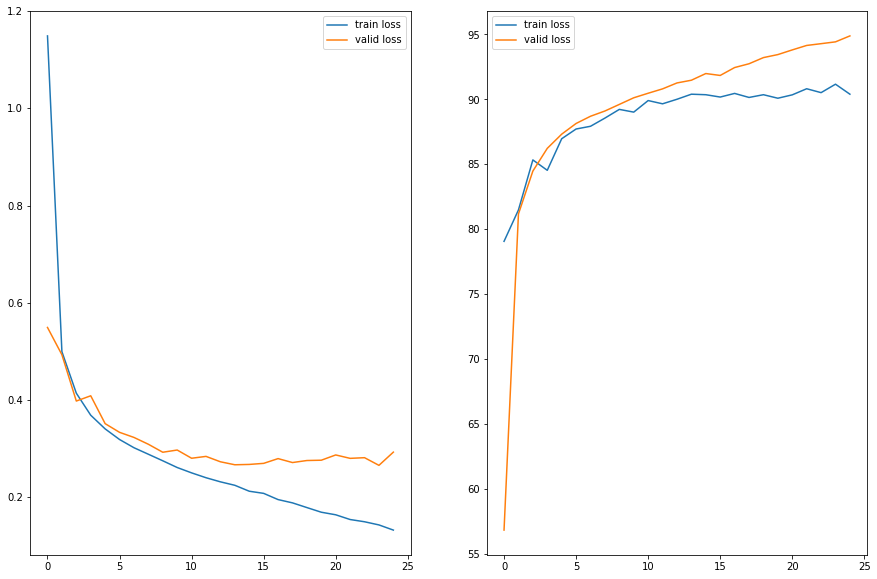

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses, label='train loss')
ax1.plot(mean_valid_losses, label='valid loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(valid_acc_list, label='valid acc')
ax2.plot(train_acc_list, label='train acc')
ax2.legend(lines, labels, loc='best')

# optimizer SGD with lr 0.01, weight decay 0.001

In [0]:
optimizer1=optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
loss_fn1 = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
mean_train_losses1 = []
mean_valid_losses1 = []
valid_acc_list1 = []
train_acc_list1=[]
start_epoch1=0
e1=5

In [17]:
for epoch in range(start_epoch1,20):
    #exp_lr_scheduler.step()
    model.train()
    
    train_losses = []
    valid_losses = []
    model.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer1.zero_grad()
        
        outputs = model(images)
        loss = loss_fn1(outputs, labels)
        loss.backward()
        optimizer1.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if (i * 100) % (100 * 100) == 0:
            print(f'{i * 100} / 50000')
            
    model.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model(images)
            loss = loss_fn1(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
            
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses1.append(m_t_l)
    mean_valid_losses1.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list1.append(accuracy_v)
    train_acc_list1.append(accuracy_t)
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer1.state_dict(), 'train loss': mean_train_losses1,'train acc': train_acc_list1, 'valid loss':mean_valid_losses1, 'valid acc': valid_acc_list1}, 'vgg16MSE.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f} valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list1),np.min( mean_train_losses1)))

0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 1, train loss : 0.3772, train acc : 86.01 valid loss : 0.3817, valid acc : 85.80%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 2, train loss : 0.3694, train acc : 86.38 valid loss : 0.3789, valid acc : 86.01%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 3, train loss : 0.3634, train acc : 86.47 valid loss : 0.3669, valid acc : 86.46%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 4, train loss : 0.3583, train acc : 86.74 valid loss : 0.3652, valid acc : 86.49%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 5, train loss : 0.3554, train acc : 86.75 valid loss : 0.3612, valid acc : 86.66%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 6, train loss : 0.3514, train acc : 87.02 valid loss : 0.3545, valid acc : 86.68%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 5000

In [0]:
checkpoint = torch.load('vgg16MSE.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer1.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch1 = checkpoint['epoch']
mean_train_losses1 = checkpoint['train loss']
train_acc_list1=checkpoint['train acc']
mean_valid_losses1 = checkpoint['valid loss']
valid_acc_list1=checkpoint['valid acc']

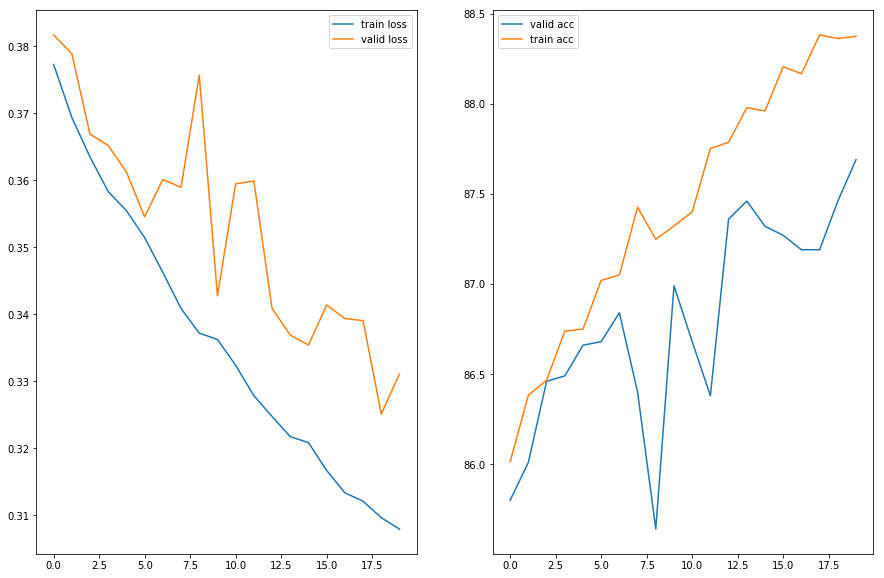

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses1, label='train loss')
ax1.plot(mean_valid_losses1, label='valid loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(valid_acc_list1, label='valid acc')
ax2.plot(train_acc_list1, label='train acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')

# optimizer SGD with lr 0.002, weight decay 0.02

In [0]:
optimizer1a=optim.SGD(model.parameters(), lr=0.002, weight_decay=0.02)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
loss_fn1a = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
mean_train_losses1a = []
mean_valid_losses1a = []
valid_acc_list1a = []
train_acc_list1a=[]
start_epoch1a=0
e1a=5

In [12]:
for epoch in range(start_epoch1a,10):
    #exp_lr_scheduler.step()
    model.train()
    
    train_losses = []
    valid_losses = []
    model.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer1a.zero_grad()
        
        outputs = model(images)
        loss = loss_fn1a(outputs, labels)
        loss.backward()
        optimizer1a.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if (i * 100) % (100 * 100) == 0:
            print(f'{i * 100} / 50000')
            
    model.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model(images)
            loss = loss_fn1a(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
            
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses1a.append(m_t_l)
    mean_valid_losses1a.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list1a.append(accuracy_v)
    train_acc_list1a.append(accuracy_t)
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer1a.state_dict(), 'train loss': mean_train_losses1a,'train acc': train_acc_list1a, 'valid loss':mean_valid_losses1a, 'valid acc': valid_acc_list1a}, 'vgg16wd0.002.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f} valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list1a),np.min( mean_train_losses1a)))

0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 6, train loss : 0.4887, train acc : 81.63 valid loss : 0.4630, valid acc : 83.18%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 7, train loss : 0.4649, train acc : 82.48 valid loss : 0.4821, valid acc : 81.80%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 8, train loss : 0.4453, train acc : 83.26 valid loss : 0.4426, valid acc : 84.02%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 9, train loss : 0.4267, train acc : 83.94 valid loss : 0.4355, valid acc : 83.74%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 10, train loss : 0.4144, train acc : 84.49 valid loss : 0.4314, valid acc : 84.01%
best val acc: 84.02, best train loss: 0.4144325537085533


In [0]:
checkpoint = torch.load('vgg16wd0.002.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer1a.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch1a = checkpoint['epoch']
mean_train_losses1a = checkpoint['train loss']
train_acc_list1a=checkpoint['train acc']
mean_valid_losses1a = checkpoint['valid loss']
valid_acc_list1a=checkpoint['valid acc']

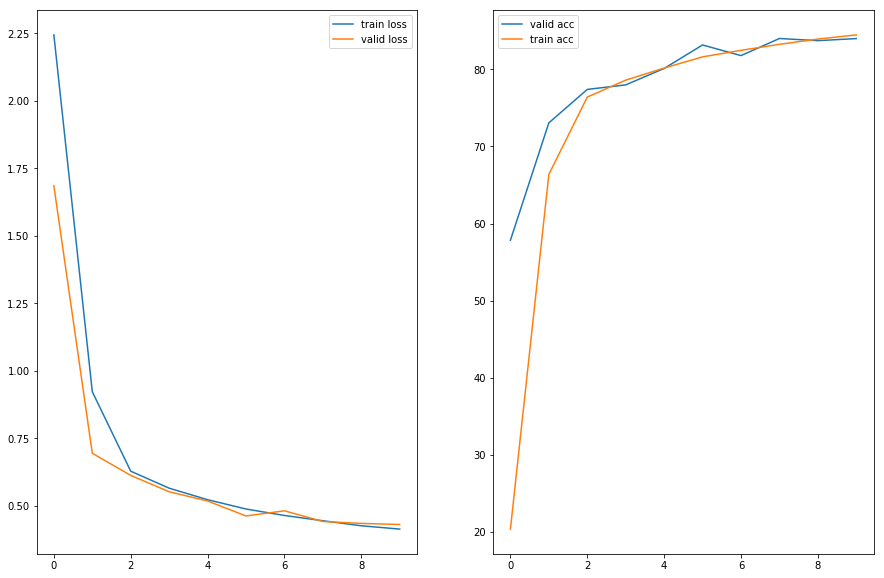

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses1a, label='train loss')
ax1.plot(mean_valid_losses1a, label='valid loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(valid_acc_list1a, label='valid acc')
ax2.plot(train_acc_list1a, label='train acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')

#optimizer sgd lr 0.001, momentum 0.5, weight decay 0.05

In [0]:
optimizer2=optim.SGD(model.parameters(), lr=0.001, momentum=0.5, weight_decay=0.05)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
loss_fn2 = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
mean_train_losses2 = []
mean_valid_losses2 = []
valid_acc_list2 = []
train_acc_list2=[]
start_epoch2=0
e2=5

In [0]:
for epoch in range(start_epoch2,10):
    #exp_lr_scheduler.step()
    model.train()
    
    train_losses = []
    valid_losses = []
    model.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer2.zero_grad()
        
        outputs = model(images)
        loss = loss_fn2(outputs, labels)
        loss.backward()
        optimizer2.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if (i * 100) % (100 * 100) == 0:
            print(f'{i * 100} / 50000')
            
    model.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model(images)
            loss = loss_fn2(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
            
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses2.append(m_t_l)
    mean_valid_losses2.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list2.append(accuracy_v)
    train_acc_list2.append(accuracy_t)
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer2.state_dict(), 'train loss': mean_train_losses2,'train acc': train_acc_list2, 'valid loss':mean_valid_losses2, 'valid acc': valid_acc_list2}, 'vgg16wd0.1.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f} valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list2),np.min( mean_train_losses2)))

0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 6, train loss : 0.4171, train acc : 84.58 valid loss : 0.4212, valid acc : 84.60%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 7, train loss : 0.4174, train acc : 84.58 valid loss : 0.4192, valid acc : 84.61%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 8, train loss : 0.4161, train acc : 84.60 valid loss : 0.4245, valid acc : 84.56%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 9, train loss : 0.4141, train acc : 84.70 valid loss : 0.4205, valid acc : 84.61%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 10, train loss : 0.4158, train acc : 84.78 valid loss : 0.4155, valid acc : 84.90%
best val acc: 84.9, best train loss: 0.41411498856544493


In [0]:
checkpoint = torch.load('vgg16wd0.1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer2.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch2 = checkpoint['epoch']
mean_train_losses2 = checkpoint['train loss']
train_acc_list2=checkpoint['train acc']
mean_valid_losses2 = checkpoint['valid loss']
valid_acc_list2=checkpoint['valid acc']

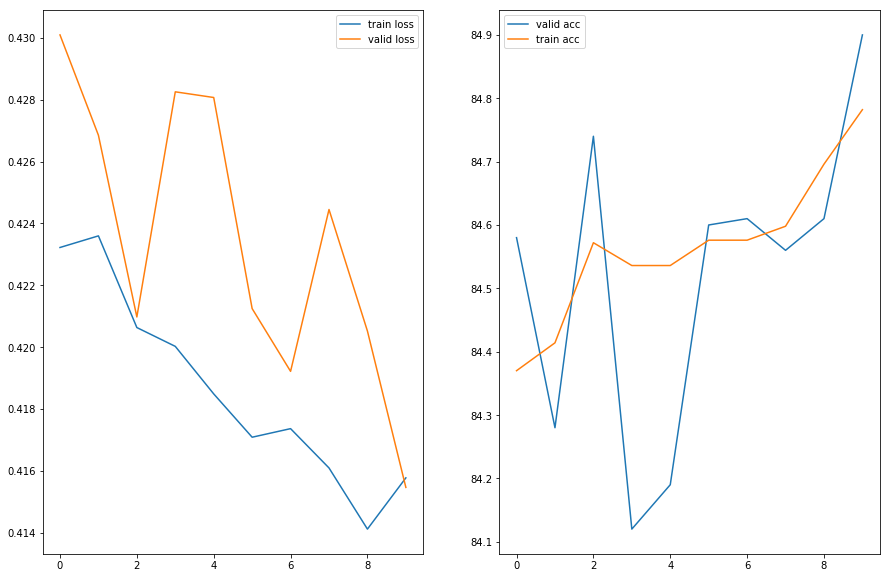

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses2, label='train loss')
ax1.plot(mean_valid_losses2, label='valid loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(valid_acc_list2, label='valid acc')
ax2.plot(train_acc_list2, label='train acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')

#sgd,lr 0.001,momentum 0.8,weight decay 0.003

In [0]:
optimizer3=optim.SGD(model.parameters(), lr=0.001, momentum=0.8, weight_decay=0.004)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
loss_fn3 = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
mean_train_losses3 = []
mean_valid_losses3 = []
valid_acc_list3 = []
train_acc_list3=[]
start_epoch3=0
e3=5

In [34]:
for epoch in range(start_epoch3,40):
    #exp_lr_scheduler.step()
    model.train()
    
    train_losses = []
    valid_losses = []
    model.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer3.zero_grad()
        
        outputs = model(images)
        loss = loss_fn3(outputs, labels)
        loss.backward()
        optimizer3.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if (i * 100) % (100 * 100) == 0:
            print(f'{i * 100} / 50000')
            
    model.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model(images)
            loss = loss_fn3(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
            
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses3.append(m_t_l)
    mean_valid_losses3.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list3.append(accuracy_v)
    train_acc_list3.append(accuracy_t)
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer3.state_dict(), 'train loss': mean_train_losses3,'train acc': train_acc_list3, 'valid loss':mean_valid_losses3, 'valid acc': valid_acc_list3}, 'vgg16m0.9w0.8.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f} valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list3),np.min( mean_train_losses3)))

0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 21, train loss : 0.2225, train acc : 91.65 valid loss : 0.2798, valid acc : 89.74%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 22, train loss : 0.2209, train acc : 91.76 valid loss : 0.2913, valid acc : 89.08%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 23, train loss : 0.2140, train acc : 92.00 valid loss : 0.2757, valid acc : 89.95%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 24, train loss : 0.2095, train acc : 92.13 valid loss : 0.2772, valid acc : 89.61%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 25, train loss : 0.2046, train acc : 92.27 valid loss : 0.2766, valid acc : 89.67%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 26, train loss : 0.1987, train acc : 92.54 valid loss : 0.2696, valid acc : 89.94%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 

In [0]:
checkpoint = torch.load('vgg16m0.9w0.8.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer3.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch3 = checkpoint['epoch']
mean_train_losses3 = checkpoint['train loss']
train_acc_list3=checkpoint['train acc']
mean_valid_losses3 = checkpoint['valid loss']
valid_acc_list3=checkpoint['valid acc']

In [39]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp '/content/vgg16m0.9w0.8.pth' '/content/drive/My Drive/Colab Notebooks'

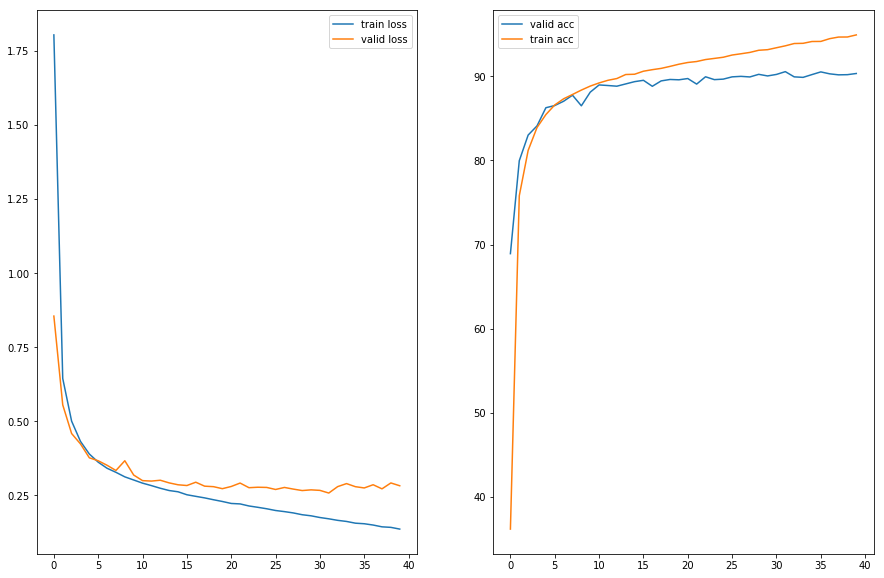

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses3, label='train loss')
ax1.plot(mean_valid_losses3, label='valid loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(valid_acc_list3, label='valid acc')
ax2.plot(train_acc_list3, label='train acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')